In [1]:
!pip install control 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 9.3 MB/s eta 0:00:00ta 0:00:01


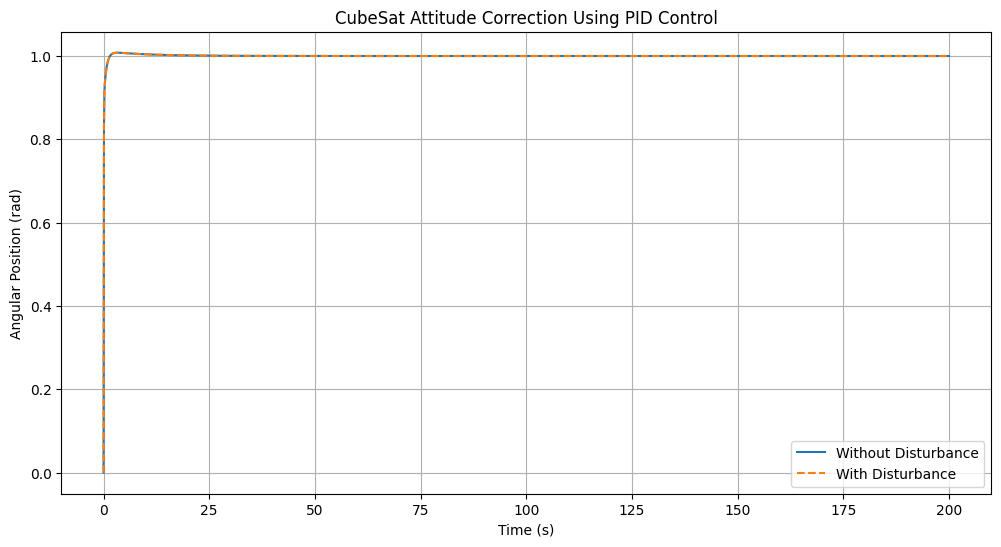

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctl

#Cubesat Parameters
mass = 1.33 #kg
side_length = 0.1 #meters
J = (1/6)*mass*side_length**2 #moment of inertia (kg.m^2)
c = 0.01 #damping coefficient (N.m.s)

#def disturbance_torque

def disturbance_torque_vectorized(t):
    #params
    mu = 3.986e14 #Earth's gravity parameter (m^3/s^2)
    r = 7000e3 #orbit radius(m)
    Jx, Jz = 2.2e-3, 2.23-3 #moments of inertia kgm^2
    rho = 1e-12 #atmospheric density (kg/m^3)
    v = 7.5e3 #Orbital velocity (m/s)
    Cd = 2.2 #Drag coefficient
    A = 0.01 #Cross-sectional area (m^2)
    l = 0.05 #Lever arm (m)
    Ps = 4.5e-6 #Solar radiation pressure (N/m^2)
    c_speed = 3e8 #speed of light (m/s)

    #Gravity Gradient Torque
    theta = 0.1*np.sin(0.1*t)
    tau_gg = (3/2)*(mu/r**3)*(Jz-Jx)*np.sin(2*theta)

    #Aerodynamic Drag Torque
    tau_drag = 0.5*rho*v**2*Cd*A*l

    #Solar Radiation Pressure Torque
    tau_srp = (Ps*A*l/ c_speed)*np.sin(theta)

    #Combined Disturbance
    return tau_gg + tau_drag + tau_srp



#Plant: Cubesat dynamics (J*s^2+c*s)
num = [1]
den = [J, c, 0]
satellite = ctl.TransferFunction(num, den)

#PID Controller Parameters
Kp = 0.1
Ki = 0.01
Kd = 0.05
pid = ctl.TransferFunction([Kd,Kp,Ki],[1,0])

#closed-loop system
closed_loop = ctl.feedback(pid*satellite, 1)

#Simulation Time
time = np.linspace(0, 200, 2000) #1000 Seconds

#Step Response Without Disturbance
_, response = ctl.step_response(closed_loop, time)

#Adding Disturbances
disturbances = disturbance_torque_vectorized(time)
response_with_disturbance = response + disturbances

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(time, response, label="Without Disturbance")
plt.plot(time, response_with_disturbance, label="With Disturbance", linestyle='--')
plt.title("CubeSat Attitude Correction Using PID Control")
plt.xlabel("Time (s)")
plt.ylabel("Angular Position (rad)")
plt.grid()
plt.legend()
plt.show()

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assuming response_with_disturbance and time are already defined

# Limit time to the first 10 seconds
time_limit = time[time <= 10]
response_with_disturbance_limit = response_with_disturbance[:len(time_limit)]

# Animation Setup
fig, ax_orbit = plt.subplots(figsize=(8, 6))

# Plot: CubeSat Attitude with Disturbances
ax_orbit.set_xlim(0, 10)  # Time axis for the first 10 seconds
ax_orbit.set_ylim(np.min(response_with_disturbance_limit) - 0.1, np.max(response_with_disturbance_limit) + 0.1)
ax_orbit.set_title("CubeSat Attitude Correction Over First 10 Seconds")
ax_orbit.set_xlabel("Time (s)")
ax_orbit.set_ylabel("Angular Position (rad)")
disturbed_satellite, = ax_orbit.plot([], [], 'g--', lw=2, label="Attitude With Disturbance")
ax_orbit.legend()

# Animation Function
def update(frame):
    # Update Attitude Plot
    disturbed_satellite.set_data(time_limit[:frame], response_with_disturbance_limit[:frame])
    return disturbed_satellite,

# Create Animation
ani = FuncAnimation(fig, update, frames=len(time_limit), interval=50, blit=True)

# Save Animation as MP4
ani.save("cubesat_attitude_with_disturbances_10ss.mp4", writer="ffmpeg", fps=30)

plt.close(fig)  # Close the figure after saving


In [14]:
print(f"Disturbance values (max, min): {np.max(disturbances)}, {np.min(disturbances)}")
print(f"Response values (max, min): {np.max(response)}, {np.min(response)}")


Disturbance values (max, min): 2.983582234251283e-07, -2.36483223551304e-07
Response values (max, min): 1.0078816345658816, 0.0
